In [1]:
#**********************************************************************************
#Fuction to create cross-sections using ICON native grid
#
#Julian Quimbayo Duarte
#Goethe Uni, 2022
#quimbayo-duarte@iau.uni-frankfurt.de
#**********************************************************************************
#--modules
import time
import xarray as xr

import numpy as np
import numpy.ma as ma

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from   matplotlib.collections import PolyCollection

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from   cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader

import math
import csv  

from scipy import interpolate
from scipy.interpolate import griddata
import sys
import datetime as dt
import os

# First Party
sys.path.append('../utilities_tlezuo/')
# from timefunctions import *
import varfunctions as vf
import locfunctions as lf
import timefunctions as tf
import get_stations_timeseries as gs

In [2]:
################################################ JULIAN FUNCTIONS #######################################
#*************************************************************************************************
#-- function to get the closer gp to coordinate
def get_indices(lats,lons,radius,LATX , LONX ):
    """ get_indices takes latitude latx and longitude lonx and
    returns the indices indexi and indexj of the nearest grid cell in a 2D array"""
    DISTANCE_TO_X = np.sqrt((lats - LATX)**2 + (lons - LONX)**2)
    indices = np.where(DISTANCE_TO_X < radius )
    return indices[0]
    pass
#*************************************************************************************************
#-- GEt the distance between two points
def haversine(lat1, lon1, lat2, lon2):
    rad=math.pi/180
    dlat=lat2-lat1
    dlon=lon2-lon1
    R=6372.795477598
    a=(math.sin(rad*dlat/2))**2 + math.cos(rad*lat1)*math.cos(rad*lat2)*(math.sin(rad*dlon/2))**2
    distancia=2*R*math.asin(math.sqrt(a))
    return distancia
#*************************************************************************************************
#-- Getting the cross-section from the native ICON grid (only one interpolation)
#-- initial and final point for the cross-section

def cross_section(A, B, Step, with_file, icon_gp_file,clon,clat,dx,topo,var,z,interp_meth):
    #-- def some arrays
    X = np.empty(10000)
    Y = np.empty(10000)

    #-- Def the line and points between coordinates (A and B points)
    #-- geo points start and end
    x1, y1 = A
    x2, y2 = B

    #-- the increment step (higher = faster)
    STEP = Step #-- Step between points
    
    print(str(x1)+str(x2))
    # print(str(x1),str(x2))
    if x1 > x2:           # x2 must be the bigger one here
        print('x1>x2')
        x1, x2 = x2, x1
        y1, y2 = y2, y1
    #-- getting the diff coordinates
        for i in range(int((x2-x1)/STEP) + 1):
            #print(i)
            x = x1 + i*STEP
            X[i] = x
            y = (y1-y2)/(x1-x2) * (x - x1) + y1
            Y[i] = y
    elif x1 < x2:
        print('x1<x2')
        # no need to change x1 with x2
    #-- getting the diff coordinates
        for i in range(int((x2-x1)/STEP) + 1):
            #print(i)
            x = x1 + i*STEP
            X[i] = x
            y = (y1-y2)/(x1-x2) * (x - x1) + y1
            Y[i] = y
    elif x1 == x2:
        print('x1=x2 ')
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        for i in range(int((y2-y1)/STEP) + 1):
            y = y1 + i*STEP
            Y[i] = y
            x = x1
            X[i] = x

    i = int((y2-y1)/STEP) + 1
    #-- storing the coordinates in an array
    coords_in_line = np.empty([i+1,2])
    coords_in_line[:-1,1] = X[:i]
    coords_in_line[:-1,0] = Y[:i]
#
    #-- cross section lat lon points
    coords_in_line[-1,1] = B[0]
    coords_in_line[-1,0] = B[1]
    print('length of points array is '+str(len(coords_in_line)))

    #-- saving the points to check them in G earth
    np.savetxt('line_coord.csv', coords_in_line, delimiter=",")
    
    if with_file == 'TRUE':
    #-- Reading the files if it is provided
        with open(icon_gp_file) as file_name:
            points_icon = np.loadtxt(file_name, delimiter=",")
    
        ccoords = np.column_stack((clon,clat))
        coords_in_line = np.empty([len(points_icon)+1,2])
        points_icon_coords = np.empty_like(coords_in_line)
    
    else:
    #-- Getting the closer points in ICON grid
    #-- def some arrays
        ccoords = np.column_stack((clon,clat))
        dist = np.empty_like(clon)
        points_icon = np.empty_like(coords_in_line)
        points_icon_coords = np.empty_like(coords_in_line)
        topo_icon = np.empty_like(coords_in_line)
#
        jj = 0
        for j in coords_in_line:
            ii=0
            for i in ccoords:
                dist[ii] = haversine(i[1],i[0],j[1],j[0]) #km
                ii=ii+1
            indices = np.where(dist < dx )  #.26 grid resolution
            bb = np.argmin(dist[indices])
            indices = np.squeeze(np.asanyarray(indices))
            points_icon[jj] = indices[bb] #Closer points in Icon
            jj=jj+1
            # print(jj)
        np.savetxt(icon_gp_file, points_icon, delimiter=",")   

        #-- Obtain the coordinates in ICON + the values for the diff sfc quantities

    topo_icon = np.empty_like(coords_in_line)
    ii = 0
    for i in (points_icon[:,0]):
        points_icon_coords[ii,:] = (ccoords[int(i)]) #Coordinates in ICON
        topo_icon[ii,:] = topo[int(i)] #Topo values for that coordinates
        ii = ii+1

    np.savetxt('grid_coord.csv', points_icon_coords, delimiter=",")
    
    #-- Def new x-array to plot the data

    cross_x = np.empty_like(coords_in_line)
    dim_coords_in_line = coords_in_line.shape 

    for i in range(0,dim_coords_in_line[0]-1):
        cross_x[i,0] = haversine(coords_in_line[i,1], coords_in_line[i,0],
                               coords_in_line[i+1,1], coords_in_line[i+1,0])
        cross_x[i,1] = sum(cross_x[0:i,0])
    #-- last item
    cross_x[-1,1] = sum(cross_x[0:i+1,0])
    #

    #-- Interpolation (regridding) for sfc data
    zz = topo_icon[:,0]
    ter = griddata(points_icon_coords, zz, coords_in_line, method=interp_meth)    
    
    #-- Interpolation 3D variables

    #-- Def some arrays
    var_icon = np.empty_like(coords_in_line)
    dim_var_icon = var_icon.shape
    dim_var = var.shape
    regrid_var = np.empty((dim_var[0],dim_var_icon[0]))
    
    z_icon = np.empty_like(coords_in_line)
    regrid_z = np.empty((dim_var[0],dim_var_icon[0]))

    for k in range(0,dim_var[0]-1):
        ii = 0
        for i in (points_icon[:,0]):
            points_icon_coords[ii,:] = (ccoords[int(i)])
            var_icon[ii,:] = var[dim_var[0]-1-k,int(i)]
            z_icon[ii,:] = z[dim_var[0]-1-k,int(i)]
            ii = ii+1
    
        var_new = var_icon[:,0]
        zz = z_icon[:,0]
    
        regrid_var[k,:] = griddata(points_icon_coords, var_new, coords_in_line, method=interp_meth)
        regrid_z[k,:] = griddata(points_icon_coords, zz, coords_in_line, method=interp_meth)/1000 # in km
    return regrid_var,regrid_z,ter,cross_x
# 3d var, vertical grid, 2d var, horizontal grid
#*************************************************************************************************

In [3]:

#*************************************************************************************************
#-- function to get the closer gp to coordinate
def get_indices(lats,lons,radius,LATX , LONX ):
    """ get_indices takes latitude latx and longitude lonx and
    returns the indices indexi and indexj of the nearest grid cell in a 2D array"""
    DISTANCE_TO_X = np.sqrt((lats - LATX)**2 + (lons - LONX)**2)
    indices = np.where(DISTANCE_TO_X < radius )
    return indices[0]
    pass
#*************************************************************************************************
#-- GEt the distance between two points
def haversine(lat1, lon1, lat2, lon2):
    rad=math.pi/180
    dlat=lat2-lat1
    dlon=lon2-lon1
    R=6372.795477598
    a=(math.sin(rad*dlat/2))**2 + math.cos(rad*lat1)*math.cos(rad*lat2)*(math.sin(rad*dlon/2))**2
    distancia=2*R*math.asin(math.sqrt(a))
    return distancia
#*************************************************************************************************
#-- Getting the cross-section from the native ICON grid (only one interpolation)
#-- initial and final point for the cross-section

def cross_section(A, B, Step, with_file, icon_gp_file,clon,clat,dx,topo,var,z,interp_meth):
    #-- def some arrays
    X = np.empty(10000)
    Y = np.empty(10000)

    #-- Def the line and points between coordinates (A and B points)
    #-- geo points start and end
    x1, y1 = A
    x2, y2 = B

    #-- the increment step (higher = faster)
    STEP = Step #-- Step between points
    
    # print(str(x1),str(x2))
    if x1 > x2:           # x2 must be the bigger one here
        print('x1>x2')
        x1, x2 = x2, x1
        y1, y2 = y2, y1
    #-- getting the diff coordinates
        for i in range(int((x2-x1)/STEP) + 1):
            #print(i)
            x = x1 + i*STEP
            X[i] = x
            y = (y1-y2)/(x1-x2) * (x - x1) + y1
            Y[i] = y
    elif x1 < x2:
        print('x1<x2')
        # no need to change x1 with x2
    #-- getting the diff coordinates
        for i in range(int((x2-x1)/STEP) + 1):
            #print(i)
            x = x1 + i*STEP
            X[i] = x
            y = (y1-y2)/(x1-x2) * (x - x1) + y1
            Y[i] = y
    elif x1 == x2:
        print('x1=x2 ')
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        for i in range(int((y2-y1)/STEP) + 1):
            y = y1 + i*STEP
            Y[i] = y
            x = x1
            X[i] = x


    #-- storing the coordinates in an array
    coords_in_line = np.empty([i+1,2])
    coords_in_line[:-1,1] = X[:i]
    coords_in_line[:-1,0] = Y[:i]
#
    #-- cross section lat lon points
    coords_in_line[-1,1] = B[0]
    coords_in_line[-1,0] = B[1]
    # print('length of points array is '+len(coords_in_line))

    #-- saving the points to check them in G earth
    np.savetxt('line_coord.csv', coords_in_line, delimiter=",")
    
    if with_file == 'TRUE':
    #-- Reading the files if it is provided
        with open(icon_gp_file) as file_name:
            points_icon = np.loadtxt(file_name, delimiter=",")
    
        ccoords = np.column_stack((clon,clat))
        points_icon_coords = np.empty_like(coords_in_line)
    
    else:
    #-- Getting the closer points in ICON grid
    #-- def some arrays
        ccoords = np.column_stack((clon,clat))
        dist = np.empty_like(clon)
        points_icon = np.empty_like(coords_in_line)
        points_icon_coords = np.empty_like(coords_in_line)
        topo_icon = np.empty_like(coords_in_line)
#
        jj = 0
        for j in coords_in_line:
            ii=0
            for i in ccoords:
                dist[ii] = haversine(i[1],i[0],j[1],j[0]) #km
                ii=ii+1
            indices = np.where(dist < dx )  #.26 grid resolution
            bb = np.argmin(dist[indices])
            indices = np.squeeze(np.asanyarray(indices))
            points_icon[jj] = indices[bb] #Closer points in Icon
            jj=jj+1
            # print(jj)
        np.savetxt(icon_gp_file, points_icon, delimiter=",")   

        #-- Obtain the coordinates in ICON + the values for the diff sfc quantities

    topo_icon = np.empty_like(coords_in_line)
    ii = 0
    for i in (points_icon[:,0]):
        points_icon_coords[ii,:] = (ccoords[int(i)]) #Coordinates in ICON
        topo_icon[ii,:] = topo[int(i)] #Topo values for that coordinates
        ii = ii+1

    np.savetxt('grid_coord.csv', points_icon_coords, delimiter=",")
    
    #-- Def new x-array to plot the data

    cross_x = np.empty_like(coords_in_line)
    dim_coords_in_line = coords_in_line.shape 

    for i in range(0,dim_coords_in_line[0]-1):
        cross_x[i,0] = haversine(coords_in_line[i,1], coords_in_line[i,0],
                               coords_in_line[i+1,1], coords_in_line[i+1,0])
        cross_x[i,1] = sum(cross_x[0:i,0])
    #-- last item
    cross_x[-1,1] = sum(cross_x[0:i+1,0])
    #

    #-- Interpolation (regridding) for sfc data
    zz = topo_icon[:,0]
    ter = griddata(points_icon_coords, zz, coords_in_line, method=interp_meth)    
    
    #-- Interpolation 3D variables

    #-- Def some arrays
    var_icon = np.empty_like(coords_in_line)
    dim_var_icon = var_icon.shape
    dim_var = var.shape
    regrid_var = np.empty((dim_var[0],dim_var_icon[0]))
    
    z_icon = np.empty_like(coords_in_line)
    regrid_z = np.empty((dim_var[0],dim_var_icon[0]))

    for k in range(0,dim_var[0]-1):
        ii = 0
        for i in (points_icon[:,0]):
            points_icon_coords[ii,:] = (ccoords[int(i)])
            var_icon[ii,:] = var[dim_var[0]-1-k,int(i)]
            z_icon[ii,:] = z[dim_var[0]-1-k,int(i)]
            ii = ii+1
    
        var_new = var_icon[:,0]
        zz = z_icon[:,0]
    
        regrid_var[k,:] = griddata(points_icon_coords, var_new, coords_in_line, method=interp_meth)
        regrid_z[k,:] = griddata(points_icon_coords, zz, coords_in_line, method=interp_meth)/1000 # in km
    return regrid_var,regrid_z,ter,cross_x
#*************************************************************************************************

In [4]:
############################################ ACROSS ALONG WIND FUNCTION ######################################
def get_components_along_perp(u, v, lats_along, lons_along, direction='along'):
    '''
    Function to calculate the wind speed along or perpenticulat to the cross
    section plane

    Parameters
    ----------
    u : np.array
        u component of wind.
    v : np.array
        v component of wind.
    lats_along : list of float
        List of latitudes of cross section points.
    lons_along : list of float
        List of longitudes of cross section points.
    direction : str, optional
        Either 'along' to calculate the wind speed along the plane or 'perp'
        to calculate the wind speed perpenticulat to the plane.
        The default is 'along'.

    Returns
    -------
    ff_out : np.array
        Wind speed either along or perpenticulat to the cross section plane.

    '''
    # Calculate the orientation of the cross section in the lat/lon room
    vec_along = np.array([lons_along[1] - lons_along[0],
                          lats_along[1] - lats_along[0]])

    # Calculate a normalized horizontal vector that's parallel to the
    # cross section
    vec_norm_along = vec_along / np.linalg.norm(vec_along)

    # Calculate a normalized horiztonal vector that's perpenticulat to the
    # cross section
    # - Calculate the cross product of the 3D cross section vector and
    #   the downward pointing normal vector ([0, 0, -1])
    vec_norm_perp = np.cross(np.append(vec_norm_along, 0), [0, 0, -1])
    # - Drop the vertical component as it is 0
    vec_norm_perp = vec_norm_perp[:2]

    # Create storage arrays
    ff_along = np.zeros(np.shape(u))
    ff_perp = np.zeros(np.shape(u))

    for ii in range(np.shape(u)[0]):
        for jj in range(np.shape(u)[1]):
            ff_along[ii, jj] = np.dot(np.array([u[ii, jj], v[ii, jj]]),
                                      vec_norm_along)
            ff_perp[ii, jj] = np.dot(np.array([u[ii, jj], v[ii, jj]]),
                                     vec_norm_perp)

    return ff_along, ff_perp


In [5]:
## GET UNIVERSAL DATA ##
# extfile: get topography and latlon grid
extfile = xr.open_dataset('/store/s83/tlezuo/external_parameter_mch_ICON_1E_R19B08_DOM1.nc')
topo_CTRL = extfile['topography_c'].values
clon_CTRL = np.rad2deg(extfile.clon.values)
clat_CTRL = np.rad2deg(extfile.clat.values)
# constfile: get z levels
constfile = xr.open_dataset('/store/s83/tlezuo/RUN2_reference/lfff00000000c.nc')
z_CTRL = np.squeeze(constfile['HHL'].values)

In [6]:


################################# DEFINING CS #######################################
# cross section metadata
def get_vcs(line,pdate):
    A = [line.latmin, line.lonmin]
    B = [line.latmax, line.lonmax]
    icon_gp_file = 'gridfiles/icon_ptos_1k_'+line.short+'.csv' # file name from which to load grid
    Step = 0.0025 #about 250 m
    interp_meth = 'cubic'
    dx_CTRL = 1

    # standard nc file
    lt = tf.get_lt(pdate, dt.datetime(2019,9,12,12,00))
    filename = tf.lfff_name(lt)
    ncfile = xr.open_dataset('/store/s83/tlezuo/RUN2_reference/out_std/'+filename)

    ################################# GET CS #######################################
    # prepare var arrays
    U_array = np.squeeze(ncfile['U'].values)
    V_array = np.squeeze(ncfile['V'].values)
    W_array = np.squeeze(ncfile['W'].values)
    T_array = np.squeeze(ncfile['T'].values)
    th_array = np.squeeze(ncfile['T'].values)*(100000/(np.squeeze(ncfile['P'].values)))**(2/7)

    # get vcs data
    regrid_CTRL_U = cross_section(A, B, Step, 'TRUE', icon_gp_file,clon_CTRL,clat_CTRL,
                                dx_CTRL,topo_CTRL,U_array,z_CTRL,interp_meth)
    regrid_CTRL_V = cross_section(A, B, Step, 'TRUE', icon_gp_file,clon_CTRL,clat_CTRL,
                                dx_CTRL,topo_CTRL,V_array,z_CTRL,interp_meth)
    regrid_CTRL_W = cross_section(A, B, Step, 'TRUE', icon_gp_file,clon_CTRL,clat_CTRL,
                                dx_CTRL,topo_CTRL,W_array,z_CTRL,interp_meth)
    regrid_CTRL_T = cross_section(A, B, Step, 'TRUE', icon_gp_file,clon_CTRL,clat_CTRL,
                                dx_CTRL,topo_CTRL,T_array,z_CTRL,interp_meth)
    regrid_CTRL_TH = cross_section(A, B, Step, 'TRUE', icon_gp_file,clon_CTRL,clat_CTRL,
                                dx_CTRL,topo_CTRL,th_array,z_CTRL,interp_meth)

    # clean vars
    VCS = {}
    VCS['U'] = regrid_CTRL_U[0]
    VCS['V'] = regrid_CTRL_V[0]
    VCS['W'] = regrid_CTRL_W[0]
    VCS['T'] = regrid_CTRL_T[0]
    VCS['TH'] = regrid_CTRL_TH[0]
    VCS['Z'] = regrid_CTRL_TH[1]
    VCS['TOPO'] = regrid_CTRL_TH[2]
    VCS['cross_x_ctrl'] = regrid_CTRL_TH[3]
    VCS['dim_theta'] = th_array.shape
    VCS['VEL_parallel'], VCS['VEL_normal'], = get_components_along_perp(VCS['U'] , VCS['V'] , [line.latmin,line.latmax], [line.lonmin,line.lonmax])
    return VCS


def plot_vcs(VCS,line,pdate,pvar,ax,cbar_plot):
    x_vert = np.linspace(0, VCS['dim_theta'][0]-1, VCS['dim_theta'][0])
    xx = np.meshgrid(VCS['cross_x_ctrl'][:,1], x_vert)
    aa =np.asarray(xx[0])

    levels_th = range(280, 320, 1)
    levels_pvar = np.arange(pvar.min,pvar.max,pvar.ticks)
    # levels_pvar = np.arange(-10,11,2)
    fontsize = 12
    #-- plotting 
    if pvar.name == 'W':
        pvar_plot = ax.contourf(aa[:-1,:-1],VCS['Z'][:-1,1:],VCS[pvar.name][:-2,1:]
                            ,extend='both',levels=levels_pvar,cmap=pvar.cmap)
    else:
        pvar_plot = ax.contourf(aa[:-1,:-1],VCS['Z'][:-1,1:],VCS[pvar.name][:-1,1:]
                            ,extend='both',levels=levels_pvar,cmap=pvar.cmap)
    th_plot = ax.contour(aa[:-1,:-1],VCS['Z'][:-1,1:],VCS['TH'][:-1,1:]
                        ,levels=levels_th,colors='grey',linewidths=0.30)
    ax.clabel(th_plot, levels_th[::2], inline=1, fontsize=10, colors = 'grey')
    #--plot terrain
    ter_line = ax.plot(aa[0,:-1],(VCS['TOPO'][1:]+10)/1000,color='k',linewidth=2) #the +10 is because of the vertical grid resolution

    # plot arrows
    dx = int(len(np.transpose(VCS['W'][:-2,1:]))/10)
    # dy = 2
    ax.quiver(aa[:-1,:-1][:,::dx],
            VCS['Z'][:-1,1:][:,::dx],
            VCS['VEL_parallel'][:-1,1:][:,::dx], #U
            VCS['W'][:-2,1:][:,::dx], #V
            scale=20, scale_units='inches',
            width=0.002)

    #-- Colorbar
    if cbar_plot == True:
        cbar = fig.colorbar(pvar_plot)
        cbar.ax.tick_params(labelsize='large')
        # ax.set_xticks(np.arange(0,6.1,1))
        cbar.set_ticks(np.arange(pvar.min,pvar.max,pvar.ticks*2))
        cbar.set_label(pvar.name+pvar.units, rotation=90,fontsize=fontsize)

    #-- axis settings
    # ax.set_xlim(0,6)
    ax.set_ylim(0,4)
    ax.set_yticks(np.arange(0,4.1,1))
    plt.setp(ax.get_xticklabels(),fontsize=fontsize)
    plt.setp(ax.get_yticklabels(),fontsize=fontsize)

    #-- titles
    ax.set_ylabel('Height [km]',fontsize=fontsize)
    ax.set_xlabel('Distance [km]',fontsize=fontsize)
    ax.set_title(pvar.name +' '+line.name+ ' '+pdate.strftime('%d.%m %H:%M'),fontsize=fontsize)
    # ax.axis('equal')
    #-- Pic frame
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5)
    return ax


x1<x2
x1<x2
x1<x2
x1<x2
x1<x2


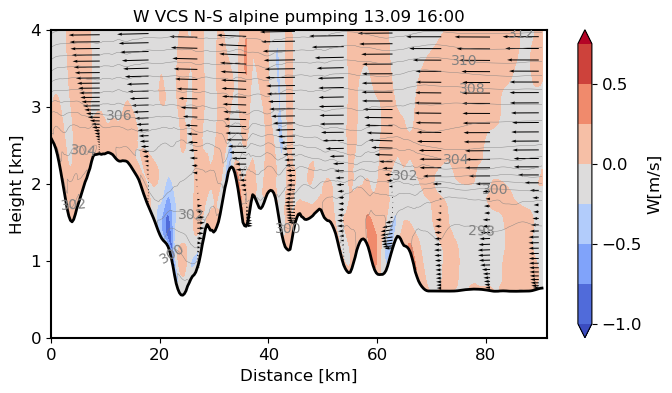

In [7]:
#################################### DECIDE #########################################
# cross section
line=lf.VCS_ap_full
# time
pdate = dt.datetime(2019,9,13,16,00)
# variable
pvar = vf.W
# get data
VCS = get_vcs(line,pdate)
################################# PLOTTING #######################################
fig,ax=plt.subplots(figsize=(8, 4))

plot_vcs(VCS,line,pdate,pvar,ax,cbar_plot=True)

################################# SAVE #######################################
outpath = 'plots/'+line.short+'/'
os.makedirs(outpath, exist_ok=True)
fig_name = pvar.name + line.short + pdate.strftime('%d%m%y_%H%M')
plt.savefig(outpath +  fig_name, bbox_inches='tight',dpi=300)

x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1>x2
x1<x2
x1<x2
x1<x2
x1<x2
x1<x2
x1<x2
x1<x2
x1<x2
x1<x2
x1<x2


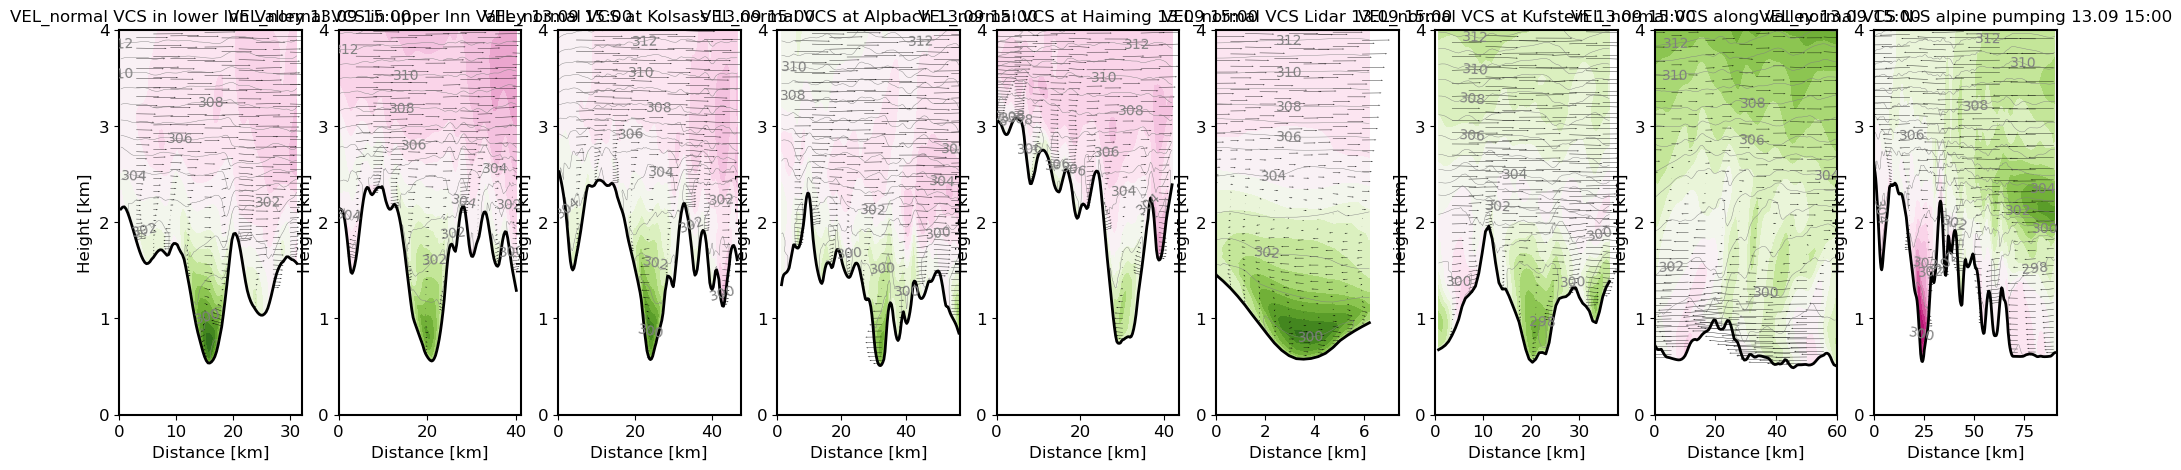

In [8]:
########################################################## 1 timestep, multiple vcs ##########################################################
#################################### DECIDE #########################################
# cross sections
VCS_lines = [lf.VCS_down_valley,lf.VCS_up_valley,lf.VCS_kols,lf.VCS_alp,lf.VCS_hai,lf.VCS_lidars_full,lf.VCS_kuf,lf.VCS_av_full_T,lf.VCS_ap_full]
# time
pdate = dt.datetime(2019,9,13,15,00)
# variable
pvar = vf.VEL_normal
fig,ax=plt.subplots(1,9,figsize=(25, 5))

for line,ax in zip(VCS_lines,ax.flatten()):
    VCS = get_vcs(line,pdate)
    plot_vcs(VCS,line,pdate,pvar,ax,cbar_plot=False)